In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytides.tide import Tide
from datetime import datetime
from scipy.optimize import curve_fit

In [2]:
gage_data = pd.read_csv('h833a.csv')

In [3]:
# store row numbers corresponding to missing data in array

data_breaks = np.where(gage_data['height'] == -32767)
# row 2568 is the first break in the record

In [4]:
# replace missing values w NaN

gage_data = gage_data.replace(-32767, np.NaN)

In [5]:
# convert to datetime format

timeseries = pd.to_datetime(gage_data[['year', 'month', 'day', 'hour']])

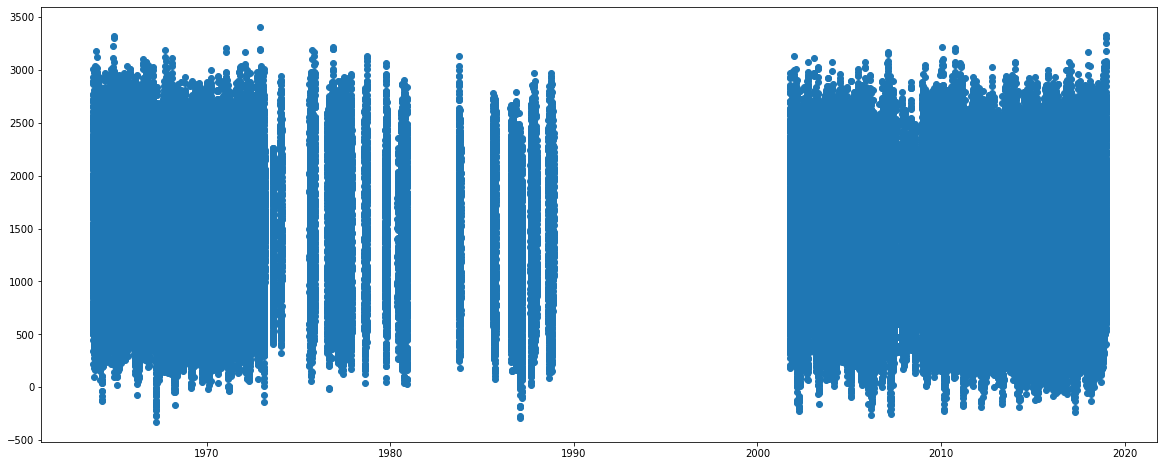

In [21]:
# plot the data

fig, ax = plt.subplots(figsize=(20,8))

ax.scatter(timeseries, gage_data['height'])

plt.show()

In [7]:
# find the mean for the entire array

h_0 = np.mean(gage_data['height'])
#h_0 

# h_0 = 1431.1514184840478

In [8]:
# subtract h_0 from each value in array
# create new array h_mean_corr with corrected values

h_mean_corr = gage_data['height']-h_0

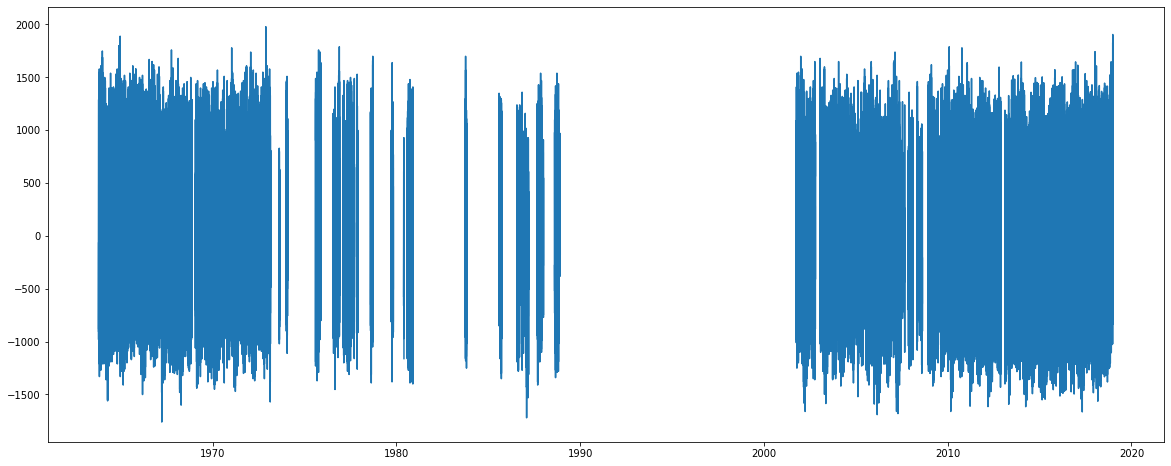

In [22]:
# check that the data is centered on 0

fig, ax = plt.subplots(figsize=(20,8))

ax.plot(timeseries, h_mean_corr)

plt.show()

In [10]:
lim_min = datetime(1963, 5, 17, 0)
lim_max = datetime(1973, 5, 17, 0)

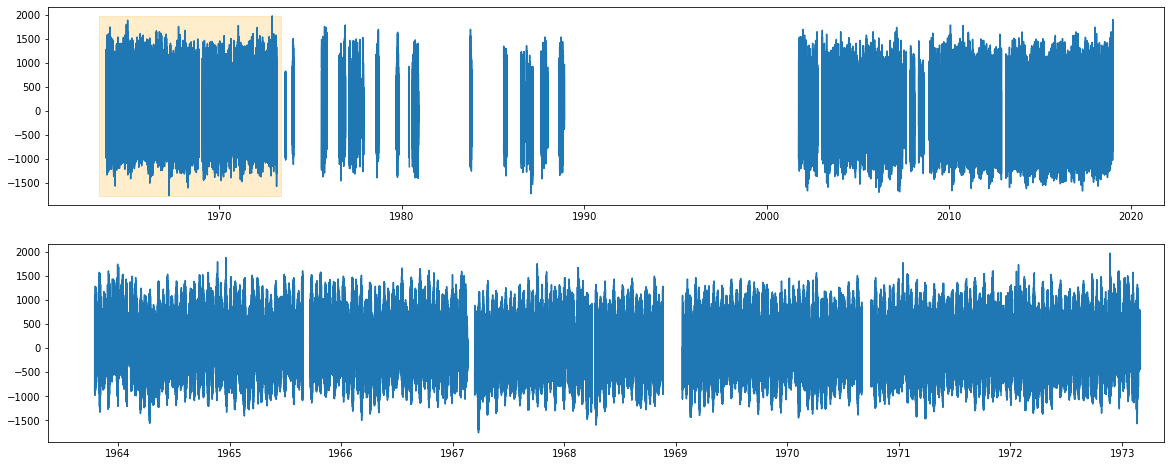

In [11]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(20,8))


# full timeseries fig
ax.plot(timeseries, h_mean_corr)

# shade region corresponding to the zoomed in plot
xlims = (lim_min, lim_max)
ax.fill_between(xlims, h_mean_corr.min(), h_mean_corr.max(), alpha=0.2, color='orange')

#zoomed in
ax1.plot(timeseries, h_mean_corr)
ax1.set_xlim(lim_min, lim_max)

plt.show()

In [12]:
# linear change in x with b intercept

def linear_fit(x, m, b):
    """Calculate linear change in *x*
    
    Parameters
    ----------
    x : float ndarray
        The x-values.
    m : float or 1-element float ndarray
        The rate of growth.
    b : float or 1-element float ndarray
        The intercept.
    
    Returns
    -------
    float ndarray
        The fitted y-values.
    
    """
    return m * x + b

In [13]:
# scipy.optimize.curve_fit handles NaN by returning all parameters as 1.0
# boolean indexing to exclude NaNs, source: https://stackoverflow.com/questions/33876226/scipy-curve-fit-fails-on-easy-linear-fit

mask_test = ~(np.isnan(h_mean_corr))

In [14]:
# create an evenly spaced line that represents the dates to simplify the regression
# array between 0, 1 
# length equal to h_mean_corr

mask_test_x = np.linspace(0,1,len(mask_test))

In [15]:
# Use non-linear least squares to fit a function, linear_fit, to data.
# returns popt: parameters that minimize least squares regression
# returns pcov: covariance

popt, pcov = curve_fit(linear_fit, mask_test_x, mask_test)
popt

array([0.22640531, 0.36612497])

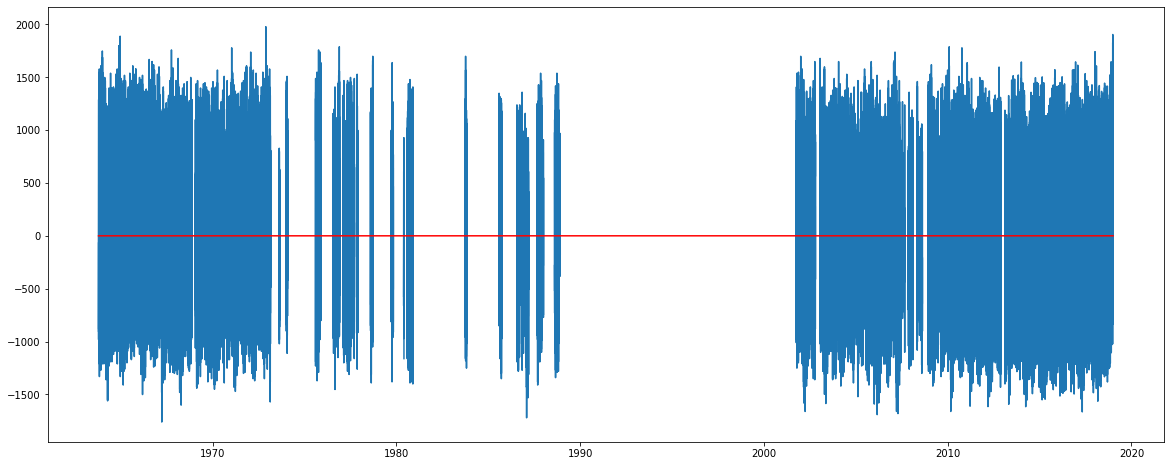

In [16]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(timeseries, h_mean_corr)

ax.plot(timeseries, linear_fit(mask_test_x, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

plt.show()

In [17]:
# i want to check that the boolean indexing is working as expected 
# create new array of gauge heights by dropping out NaNs

drop_test = h_mean_corr.dropna()

In [18]:
# repeat: make a linearly spaced x array

drop_test_x = np.linspace(0,1,len(drop_test))

In [19]:
# repeat: best fit params and covariance to function

popt, pcov = curve_fit(linear_fit, drop_test_x, drop_test)
popt

array([-152.53270847,   76.26635418])

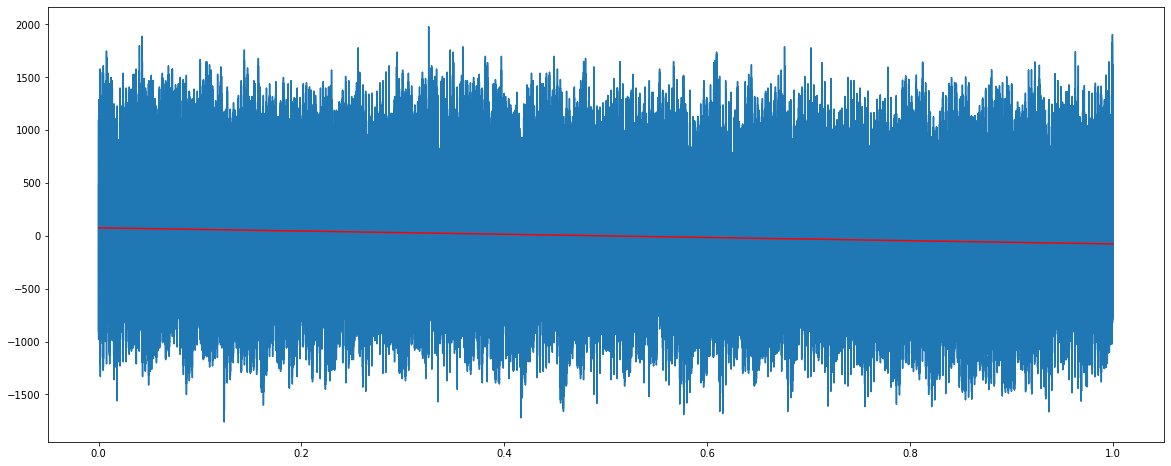

In [20]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(drop_test_x, drop_test)

# linear fit using the array 
ax.plot(drop_test_x, linear_fit(drop_test_x, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

plt.show()